### Import libraries and read in file

In [167]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# models and stuff
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [168]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [169]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

## Features

In [170]:
def feature_creation(df):
    # starting features
    feature_cols = ['main_house_total','Temp (C)','Rel Hum (%)']
    
    # time-based features
    # only hour ever seemed to matter
#     df['dow'] = df.index.weekday
#     df['weekday'] = (df.index.weekday < 5)*1
#     df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
    df['hour'] = df.index.hour
    feature_cols.append('hour')

    # season dummies
    # pretty much never important
#     df['winter'] = (df.index.month<=3)*1
#     df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
#     df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
#     df['fall'] = (df.index.month>9)*1

    # main house power percentage change and diff
    # pretty much never important
#     for interval in [1,3,5,9,15]:
#         df['mht_pct_'+str(interval)] = df['main_house_total'].pct_change(freq='1Min').fillna(0).replace(np.inf,1000)
#         df['mht_diff_'+str(interval)] = df['main_house_total'].diff(periods=1).fillna(0)
    
    # rolling stats
    # smaller values seems to do better, which makes sense
    for time_val in [5,10,15,30,60]:
        df['rolling_sum_'+str(time_val)] = df['main_house_total'].rolling(time_val).sum().fillna(0)
        df['rolling_mean_'+str(time_val)] = df['main_house_total'].rolling(time_val).mean().fillna(0)
        df['rolling_max_'+str(time_val)]  = df['main_house_total'].rolling(time_val).max().fillna(0)
        df['rolling_min_'+str(time_val)]  = df['main_house_total'].rolling(time_val).min().fillna(0)
        df['rolling_median_'+str(time_val)]  = df['main_house_total'].rolling(time_val).median().fillna(0)
        feature_cols.append('rolling_sum_'+str(time_val))
        feature_cols.append('rolling_mean_'+str(time_val))
        feature_cols.append('rolling_max_'+str(time_val))
        feature_cols.append('rolling_min_'+str(time_val))
        feature_cols.append('rolling_median_'+str(time_val))

    return feature_cols

## Modelling Functions

In [171]:
def tts(X,y,percent=0.66):
    train_size = int(len(X) * percent)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    return X_train, X_test, y_train, y_test

In [172]:
def tts_small(X,y,first_split=0.33,second_split=0.66):
    train_size = int(len(X) * first_split)
    test_size = int(len(X) * second_split)
    X_train, X_test = X[0:train_size], X[train_size:test_size]
    y_train, y_test = y[0:train_size], y[train_size:test_size]
    return X_train, X_test, y_train, y_test

In [173]:
def model_chooser(model_type,X_train,X_test,y_train,n_estimators=10,max_features='auto'):
    if model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'extra_trees':
        model = ExtraTreesClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'ada_boost':
        model = AdaBoostClassifier(random_state=42,n_estimators=n_estimators)
    elif model_type == 'gradient_boost':
        model = GradientBoostingClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    else:
        model = None

    # fit and predict on model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    return model, y_pred, y_pred_proba

In [174]:
def print_accuracies(lbl,y_test,y_pred,y_pred_proba):
    print(lbl)
    # Predict appliances are always OFF
    y_null = np.zeros(len(y_test))
    print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))

    # total accuracy
    print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Log Loss: {:0.4f}'.format(metrics.log_loss(y_test,y_pred_proba)))

    # binary accuracy
    print('Accuracy Score 1s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
    print('Accuracy Score 0s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
    
    # confusion matrix
    print(metrics.confusion_matrix(y_test,y_pred))

In [175]:
def save_accuracies(lbl,model_type,y_test,y_pred,y_pred_proba):
    dct = {}
    y_null = np.zeros(len(y_test))
    dct[model_type+'_null_accuracy'] = metrics.accuracy_score(y_test, y_null)
    dct[model_type+'_total_accuracy'] = metrics.accuracy_score(y_test, y_pred)
    dct[model_type+'_log_loss'] = metrics.log_loss(y_test,y_pred_proba)
    dct[model_type+'_accuracy_1'] = metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])
    dct[model_type+'_accuracy_0'] = metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])
    return dct                                  

### Category 2 - ON/OFF Rooms
Rooms with switches that can be turned ON/OFF (lights, phone chargers, etc.)

When room is in use, power change is incremental and relatively small. For example, a bedroom could have a light turned on or a phone plugged in, but any increase or decrease in power would be small as compared to a dishwasher or dryer.

When all switches OFF, power may not be 0 due to plug loads (alarm clocks, safety lights, etc.)

Hypothesis: If I could accurately classify a simple load like dining room, I could use that model to make the other ones a lot better. This one might work well because it has obvious peaks at night when everyone sits down for dinner

In [42]:
# label rooms using basic logic
thresh = 15
lbl = 'south_br'
df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > thresh else 0)
    
# plot to see if it makes sense
mask = (df.index.year==2012)&(df.index.week==40) # &(df.index.day==12)
df[lbl][mask].plot(linewidth=2,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

In [ ]:
rooms = ['north_br','south_br','basement','workbench','garage','dining_room','outside_plug','office','entertainment','utility_room']
df['all_rooms'] = df[rooms].sum(axis=1)

In [176]:
def categorize_rooms(df,lbl,feature_cols,model_type='random_forest',thresh=15):
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > thresh else 0)
    
    # define X, y
    X = df[feature_cols]
    y = df[lbl+'_on']

    # train test split time series manually
    X_train, X_test, y_train, y_test = tts(X,y)
    
    # fit/predict model
    model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train)
    
    # print errors
    print_accuracies(lbl,y_test,y_pred,y_pred_proba)

    return model

In [ ]:
feature_cols = feature_creation(df)
model = categorize_rooms(df,'all_rooms',feature_cols,thresh=25)
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False);

## Category 1 - ON/OFF Appliances
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [177]:
# classify power_on based only on power > 0
on_off_apps = ['dishwasher', 'oven', 'dryer', 'washer']
for lbl in on_off_apps:
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > 0 else 0)
    
df['any_on_off_app_on'] = np.where(df[on_off_apps].sum(axis=1) >= 1, 1, 0)

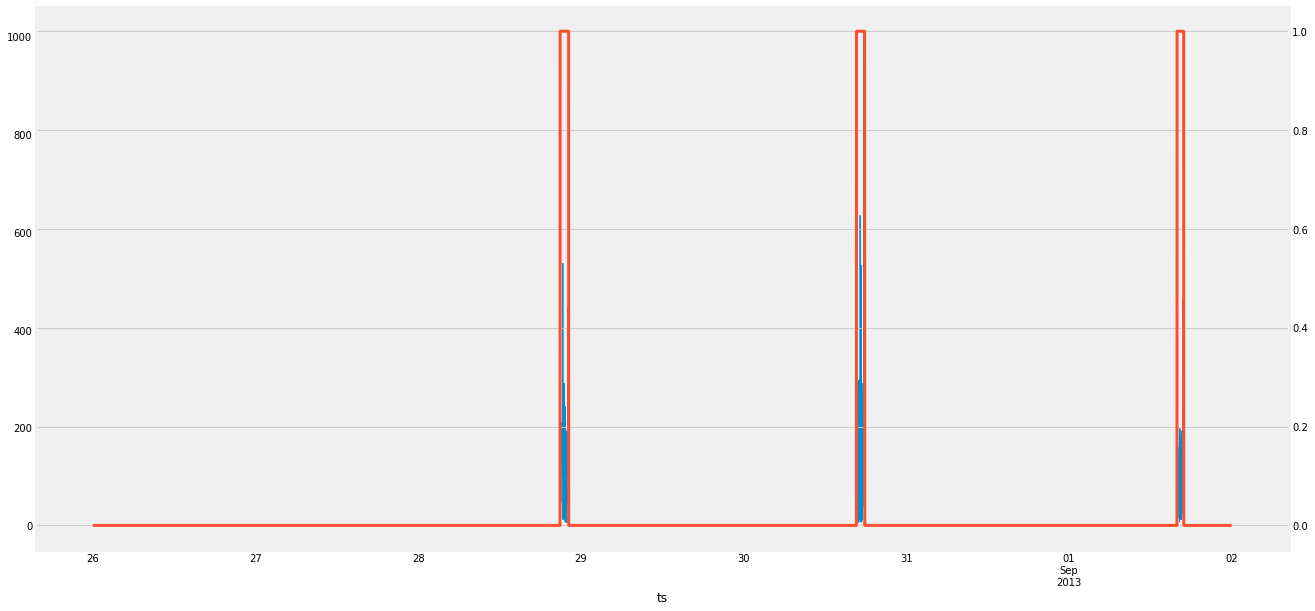

In [6]:
# plot to see if it makes sense
lbl = 'washer'
mask = (df.index.week==35)&(df.index.year==2013) # &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=3,figsize=(20,10));

In some cases this methodology shows appliances turning on when they are not actually on (if power meter registers a non zero load for whatever reason). The methodology also shows appliances turning off midway through their usage (e.g., If the dishwasher has a small "off" period mid cycle) however, it seems like this basic methodology determines the power ON/OFF accurately most of the time (based on visual inspection).

I may need to revisit this if turns out to be whack. It would also be nice if I could quantify the accuracy of this methodology.

## Basic Classification Model

In [189]:
def basic_app_class(df,lbl,feature_cols, model_type='random_forest', 
                    first_split=0.33, second_split=0.40, n_estimators=10,max_features='auto'):
    # define X, y
    X = df[feature_cols]
    y = df[lbl+'_on']

    # train test split time series manually
    X_train, X_test, y_train, y_test = tts_small(X,y,first_split=first_split,second_split=second_split)
    model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators = n_estimators, max_features = max_features)

    print_accuracies(lbl,y_test,y_pred,y_pred_proba)
    dct = save_accuracies(lbl,model_type,y_test,y_pred,y_pred_proba)
    
    return model, y_pred, y_pred_proba, dct

In [192]:
lbl = 'any_on_off_app'
feature_cols = feature_creation(df)
model_type = 'extra_trees'

model, y_pred, y_pred_proba, dct = basic_app_class(df,lbl,feature_cols, model_type=model_type, 
                    first_split=0.66, second_split=1.00, n_estimators=100,max_features='auto')

any_on_off_app
Null Accuracy Score: 0.8869
Total Accuracy Score: 0.9272
Log Loss: 0.2234
Accuracy Score 1s: 0.3903
Accuracy Score 0s: 0.9957
[[315487   1371]
 [ 24637  15771]]


In [193]:
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
pd.DataFrame(metrics.confusion_matrix(y_test,y_pred),columns=['0','1'])

Total Accuracy Score: 0.9272
             precision    recall  f1-score   support

          0       0.93      1.00      0.96    316858
          1       0.92      0.39      0.55     40408

avg / total       0.93      0.93      0.91    357266



,0,1
0,315487,1371
1,24637,15771


In [194]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

,0,1
21,rolling_max_30,0.057221
16,rolling_max_15,0.053140
11,rolling_max_10,0.050053
26,rolling_max_60,0.049707
3,hour,0.048080
6,rolling_max_5,0.039610
28,rolling_median_60,0.036425
22,rolling_min_30,0.036023
23,rolling_median_30,0.034644
25,rolling_mean_60,0.034382


In [ ]:
## Hyperparameter tuning
lbl = 'any_on_off_app'
feature_cols = feature_creation(df)
model_type = 'random_forest'
for n in estimator_range:
    model, y_pred, y_pred_proba, dct = basic_app_class(df,lbl,feature_cols, model_type='random_forest', 
                                                   first_split=0.20, second_split=0.40, 
                                                   n_estimators=100,max_features='auto')
    accuracy_scores.append(dct['random_forest_total_accuracy'])
    print(n)

In [ ]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy Score')

## Classification model with model output as feature

In [84]:
def sub_model(dataframe,sub_labels,feature_cols,model_type='random_forest',thresh=25):
    for sub_label in sub_labels:
        model = categorize_rooms(dataframe,sub_label,feature_cols,model_type=model_type,thresh=thresh)
        dataframe[sub_label+'_on'] = model.predict(dataframe[feature_cols])
        feature_cols.append(sub_label+'_on')

    return dataframe, feature_cols

In [98]:
def categorize_appliance(dataframe,y_label,sub_labels,feature_cols,model_type='logistic_regression',thresh=25):    
    dataframe, feature_cols = sub_model(dataframe,sub_labels,feature_cols,model_type=model_type,thresh=thresh)
    
    # define X, y
    X = dataframe[feature_cols]
    y = dataframe[y_label+'_on']

    # train test split time series manually
    X_train, X_test, y_train, y_test = tts(X,y)
    
    # fit/predict model
    model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train)
    
    # print errors
    print_accuracies(y_label,y_test,y_pred,y_pred_proba)

    return model, X_test, y_test, y_pred, y_pred_proba

In [99]:
feature_cols = feature_creation(df)
# rooms = ['north_br','south_br','basement','workbench','garage','office','entertainment','utility_room']
rooms = ['south_br']
model, X_test, y_test, y_pred, y_pred_proba = categorize_appliance(df,'any_on_off_app',rooms,feature_cols,model_type='random_forest',thresh=25)

south_br
Null Accuracy Score: 0.7117
Total Accuracy Score: 0.8051
Log Loss: 0.7445
Accuracy Score 1s: 0.4962
Accuracy Score 0s: 0.9302
[[236514  17753]
 [ 51896  51103]]
any_on_off_app
Null Accuracy Score: 0.8869
Total Accuracy Score: 0.9228
Log Loss: 0.7301
Accuracy Score 1s: 0.3748
Accuracy Score 0s: 0.9927
[[314538   2320]
 [ 25265  15143]]


In [126]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False);

In [134]:
foo = pd.DataFrame({'y_test':y_test,'y_pred':y_pred,'y_pred_proba':y_pred_proba})
bar = pd.concat([foo,X_test],axis=1) 
baz = bar.merge(df[['dishwasher','dryer','oven','washer']],left_index=True,right_index=True,how='left')
exploratory = baz[(baz.y_test==1)&(baz.y_pred==0)]
huh = baz[(baz.y_test==0)&(baz.y_pred==1)]
# exploratory.to_csv('/users/ianmyjer/desktop/exploratory.csv')

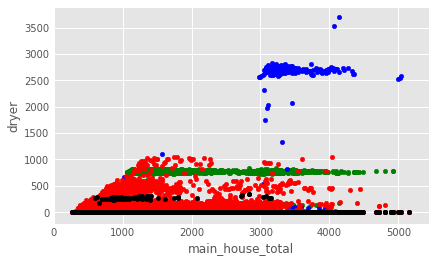

In [133]:
ax = exploratory.plot(x='main_house_total',y='dishwasher',kind='scatter',color='Green');
exploratory.plot(x='main_house_total',y='oven',kind='scatter',ax=ax,color='Blue');
exploratory.plot(x='main_house_total',y='washer',kind='scatter',ax=ax,color='Red');
exploratory.plot(x='main_house_total',y='dryer',kind='scatter',ax=ax,color='Black');

### Category 3: On-Demand Appliances

Appliances that turn on and off automatically based on demand

In [ ]:
od_apps = ['dhw_heater','refrigerator']

In [ ]:
for lbl in od_apps: 
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > 10 else 0)

In [ ]:
lbl = 'refrigerator'
mask = (df.index.week==33)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

In [ ]:
rooms = ['south_br'] # ,'north_br','basement','workbench','garage','office','entertainment','utility_room']
feature_cols = feature_creation(df)
model = categorize_appliance(df,'refrigerator',rooms,feature_cols,model_type='random forest',thresh=25)


In [ ]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

### Category 4: Weather dependent appliances

Appliances that run automatically and may draw power based on the outdoor weather

In [ ]:
wd_apps = ['furnace_fan','heat_pump']

In [ ]:
lbl = 'heat_pump'
mask = (df.index.month==10)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df['Temp (C)'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10))
# df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));